In [7]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [8]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 8)
        cb.set_ticks(tticks, fontsize = 80)
        cb.ax.tick_params(labelsize=8)
    return cb

In [9]:
## regridding steps to make the starting nc:
# 0 ) SOZONE/windAnalyis/paperFigures/runnerMakeWspd.py
# 1) /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/paperFigures/runnerLatLonsForRegrid.py
# 2) cdo remapbil,r360x180 /gpfs/data/greenocean/software/resources/windsProcessed/UKESM_1FA_wspd_2017_4regrid.nc
# 3) SOZONE/windAnalyis/paperFigures/runnerMakeClimatologyWspd.py

In [10]:
tdir = '/gpfs/data/greenocean/software/resources/windsProcessed/'

ukesm_clim = 'UKESM_1H_wspd_clim_1940-2020_regrid.nc'
era5_clim = 'ERA5_wspd_clim_1940-2020_regrid.nc'

ukesm_winds = xr.open_dataset(f'{tdir}/{ukesm_clim}')
era5_winds = xr.open_dataset(f'{tdir}/{era5_clim}')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


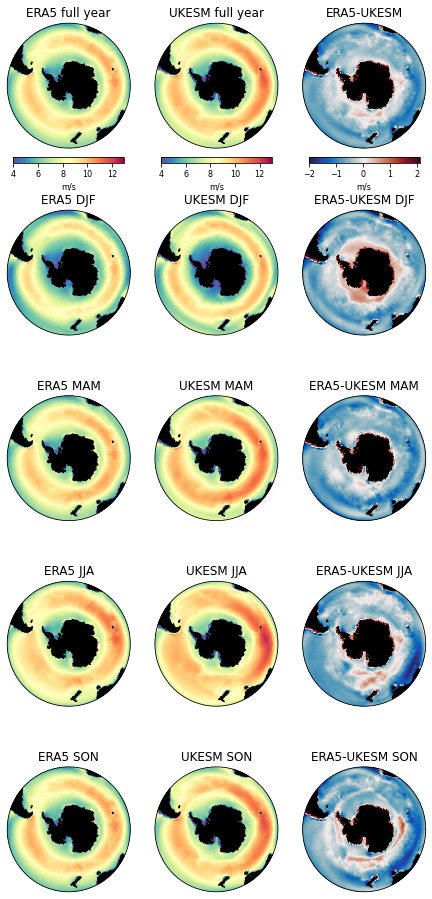

In [11]:
spbot = 4; sptop = 13; spint = 2
difbot = -2; diftop = 2.1; difint = 1
tcm = 'Spectral_r'

lats = era5_winds.lat
lons = era5_winds.lon

fact = 0.25
fig = plt.figure(figsize=[30*fact, 66*fact])


tits = ['ERA5 full year', 'UKESM full year', 'ERA5-UKESM',
       'ERA5 DJF', 'UKESM DJF', 'ERA5-UKESM DJF','ERA5 MAM', 'UKESM MAM', 'ERA5-UKESM MAM',\
        'ERA5 JJA', 'UKESM JJA', 'ERA5-UKESM JJA','ERA5 SON', 'UKESM SON', 'ERA5-UKESM SON']

toplot = [era5_winds.wspd[0,:,:].values, ukesm_winds.wspd[0,:,:].values,\
          era5_winds.wspd[0,:,:].values -ukesm_winds.wspd[0,:,:].values,\
          era5_winds.wspd[1,:,:].values, ukesm_winds.wspd[1,:,:].values,\
          era5_winds.wspd[1,:,:].values -ukesm_winds.wspd[1,:,:].values,\
          era5_winds.wspd[2,:,:].values, ukesm_winds.wspd[2,:,:].values,\
          era5_winds.wspd[2,:,:].values -ukesm_winds.wspd[2,:,:].values,\
          era5_winds.wspd[3,:,:].values, ukesm_winds.wspd[3,:,:].values,\
          era5_winds.wspd[3,:,:].values -ukesm_winds.wspd[3,:,:].values,\
          era5_winds.wspd[4,:,:].values, ukesm_winds.wspd[4,:,:].values,\
          era5_winds.wspd[4,:,:].values -ukesm_winds.wspd[4,:,:].values,\
         ]
      
cms = [tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance]
bb = [spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot, spbot, spbot, difbot]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop, sptop, sptop, diftop]
intvl = [spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint]
#test = seasmean_map_ts_ukesm[0,0,:,:]


for i in range(0,15):
    test = toplot[i]
    botbound = bb[i]
    topbound = tb[i]
    tint = intvl[i]
    if i < 3:
        tcbr = True
    else:
        tcbr = False
    ax1 = fig.add_subplot(5, 3, i+1, projection=ccrs.Orthographic(0, -90))
    bc = plot_southern(fig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), fs = 12, 
                  tit = tits[i], cbarlab = 'm/s', tcmap = cms[i], lm = True, cbr = tcbr)
    
#plt.suptitle('seasonal wind speed climatology, 1950-2020', y = 0.90)
plt.tight_layout()
fig.savefig('./figs/Fig_climatologymap_UKESM_ERA.jpg', dpi = 300)

### Hovmoller plots

In [12]:
## make binary landmask - weights on an equal grid are simple, by definition. glodap's grid is shifted for whatever reason
w = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TCO2.nc')
w2 = xr.open_dataset('/gpfs/data/greenocean/software/resources/windsProcessed/UKESM_1FA_wspd_2021_regridded.nc') #get lats and lons from here

mmask_unrot = w.TCO2[0,:,:].values
mmask_unrot[mmask_unrot >0] =1
mmask_unrot[np.isnan(mmask_unrot)] = 0 

## rotate glodap mask to match cdo mask
mmask_rot = np.zeros_like(mmask_unrot)
mmask_rot[:,0:20] = mmask_unrot[:,340:360]
mmask_rot[:,20:360] = mmask_unrot[:,0:340]

# plt.figure()
# plt.pcolormesh(mmask_unrot)
# plt.figure()
# plt.pcolormesh(mmask_rot)

savenam = 'test2.nc'
data_vars = {'mask':(['lat', 'lon'], mmask_rot,
    {'units': 'µatm',
    'long_name':'Surface ocean pCO2'}),
    }
# define coordinates
coords = {
    'lat': (['lat'], w2.lat),
    'lon': (['lon'], w2.lon),
    }
# define global attributes
attrs = {'made in':'SOZONE/windAnalyis/paperFigures/regridded_partAfigures.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
cdo_mask = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)

In [17]:
def make_yearlist(yrst, yrend, tr = 'UKESM'):
    
    baseDir = '/gpfs/data/greenocean/software/resources/windsProcessed/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        if tr == 'UKESM':
            if yr <2015:
                scen = '1H'
            else:
                scen = '1FA'
            ty = f'{baseDir}/{tr}_{scen}*wspd*{yrs[i]}*regridded.nc'
            t2 = glob.glob(ty)
        if tr == 'ERA5':
            ty = f'{baseDir}/{tr}_v2023*wspd*{yrs[i]}*regridded.nc'
            t2 = glob.glob(ty)
        #print(t2[0])
        ylist.append(t2[0])
    return ylist

tylist_ukesm = make_yearlist(1940,2021)
ukesm_wind = xr.open_mfdataset(tylist_ukesm)
tylist_era = make_yearlist(1940,2021, tr = 'ERA5')
era_wind = xr.open_mfdataset(tylist_era)

hovmol_ukesm = ukesm_wind.isel(lat = slice(0,60)).weighted(cdo_mask.mask.isel(lat = slice(0,60))).mean(dim = ['lon'])
hovmol_era5 = era_wind.isel(lat = slice(0,60)).weighted(cdo_mask.mask.isel(lat = slice(0,60))).mean(dim = ['lon'])


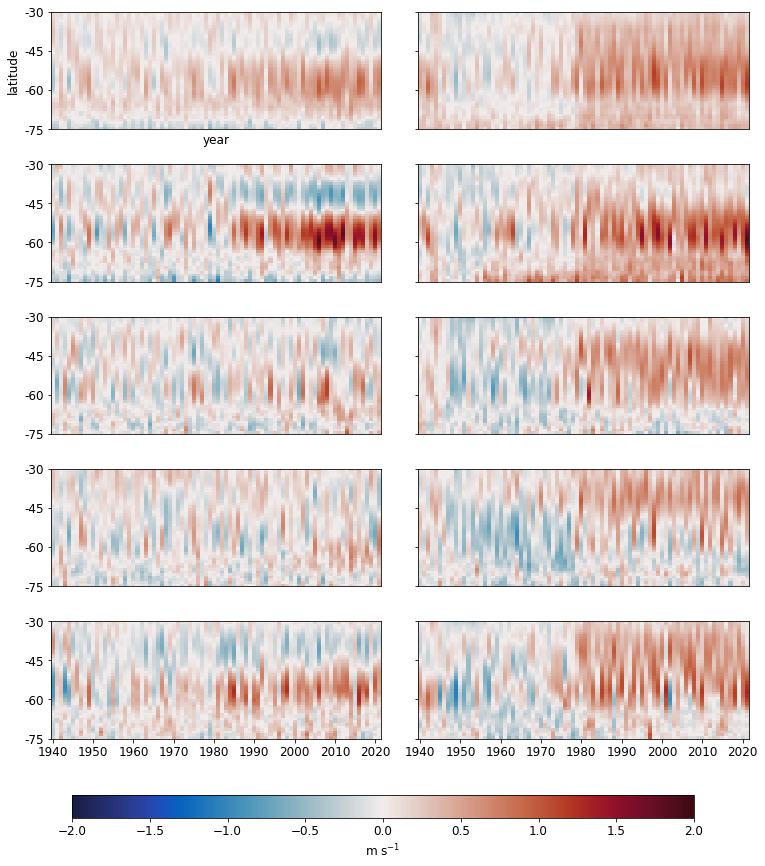

In [18]:
tt = True # for testing layout calculate only one hovmoller
tvmin = -2; tvmax = 2
tcm = cm.balance

fact = 0.9
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

ind = 0
test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
test_1950 = hovmol_ukesm.wspd.sel(time_counter =slice("1940-01-01", "1950-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
w = xr.plot.pcolormesh(test - test_1950, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


if tt:
    test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
    #########
    ind = 1
    test = hovmol_era5.wspd.groupby('time_counter.year').mean().T
    test_1950 = hovmol_era5.wspd.sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    w = xr.plot.pcolormesh(test - test_1950, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

    test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
    test_1950 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).sel(time_counter =slice("1940-01-01", "1950-01-02")).\
    groupby('time_counter.year').mean().mean(dim = 'year').T
    xr.plot.pcolormesh(test - test_1950, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


fs = 12

# axs[0].set_title('UKESM, full year', fontsize = fs)
# axs[2].set_title('UKESM, DJF', fontsize = fs)
# axs[4].set_title('UKESM, MAM', fontsize = fs)
# axs[6].set_title('UKESM, JJA', fontsize = fs)
# axs[8].set_title('UKESM, SON', fontsize = fs)

# ind = 1
# axs[0+ind].set_title('ERA5, full year', fontsize = fs)
# axs[2+ind].set_title('ERA5, DJF', fontsize = fs)
# axs[4+ind].set_title('ERA5, MAM', fontsize = fs)
# axs[6+ind].set_title('ERA5, JJA', fontsize = fs)
# axs[8+ind].set_title('ERA5, SON', fontsize = fs)

for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
for i in range(0,8):
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    
    
# axs[0].set_yticks(tind)
# axs[0].set_yticklabels(tind_lat)
axs[0].set_yticks(np.arange(-75,-15,15))
axs[0].set_yticklabels(np.arange(-75,-15,15))
axs[0].set_ylabel('latitude')    
    
for i in range(0,10):
    axs[i].set_ylim([-75,-30])
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
plt.tight_layout()
plt.show()
fig.savefig('./figs/Fig-hovmoller-diffraw.jpg')